In [48]:
import numpy as np
import scipy.io
from scipy import signal
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt
import seaborn as sns
from braindecode.models import EEGNetv4
import copy
import random
import pandas as pd
import tqdm


torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650'

# Funções de apoio

In [8]:
def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Curva de Perda
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Perda Treinamento")
    plt.plot(epochs, val_losses, label="Perda Validação")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Curva de Perda: Treino e validação")

    # Curva de Acurácia
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Acurácia Treinamento")
    plt.plot(epochs, val_accuracies, label="Acurácia Validação")
    plt.xlabel("Épocas")
    plt.ylabel("Acurácia (%)")
    plt.legend()
    plt.title("Curva de Acurácia: Treino e validação")

    plt.tight_layout()
    plt.show()

In [9]:
def separar_em_janelas(matriz, tamanho_janela, incluir_ultimo=False):
    # Calcular o número total de linhas
    total_linhas = matriz.shape[0]

    # Calcular o número de grupos necessário
    num_janelas = total_linhas // tamanho_janela

    # Inicializar uma lista vazia para armazenar os grupos
    janelas = []

    # Iterar sobre a matriz, pegando as linhas de tamanho_grupo em tamanho_grupo e armazenando em grupos
    for i in range(0, total_linhas, tamanho_janela):
        janela = matriz[i : i + tamanho_janela]  # Pegar o grupo de tamanho_grupo linhas
        janelas.append(janela)  # Adicionar o grupo à lista

    # Se incluir_ultimo for False e houver linhas restantes, remover o último grupo
    if not incluir_ultimo and total_linhas % tamanho_janela != 0:
        janelas.pop()

    return janelas, num_janelas

In [10]:
def bandpass_filter(
    dados, taxa_amostragem, freq_corte_low, freq_corte_high, ordem_filtro
):
    """
    Filtra dados EEG utilizando um filtro Butterworth passa-banda.
    Parâmetros:
    dados (ndarray): Dados do EEG com formato (número de eletrodos, número de amostras, número de frequências, número de trials).
    taxa_amostragem (int): Frequência de amostragem dos sinais EEG (Hz).
    freq_corte_low (float): Frequência de corte inferior do filtro passa-banda (Hz).
    freq_corte_high (float): Frequência de corte superior do filtro passa-banda (Hz).
    ordem_filtro (int): Ordem do filtro Butterworth.

    Retorna:
    ndarray: Dados EEG filtrados.
    """

    # **Construção do filtro passa-banda**
    # Cria o filtro passa-banda com os parâmetros especificados
    b, a = signal.butter(
        ordem_filtro,
        [freq_corte_low, freq_corte_high],
        btype="bandpass",
        analog=False,
        output="ba",
        fs=taxa_amostragem,
    )

    # **Filtragem dos dados**
    # Realiza o processo de filtragem para todas as frequências, trials e eletrodos
    num_eletrodos, num_amostras, num_freqs, num_trials = dados.shape

    filtered_data = np.zeros_like(dados)
    # Filtra os dados para cada frequência, trial e eletrodo
    for f in range(num_freqs):  # Para cada frequência de estimulação
        for trial in range(num_trials):  # Para cada trial
            for eletrodo in range(num_eletrodos):  # Para cada eletrodo
                # Filtra o sinal com o filtro de fase zero
                eletrodo_filtrado = signal.filtfilt(b, a, dados[eletrodo, :, f, trial])
                # Substitui o dado original pelo filtrado
                filtered_data[eletrodo, :, f, trial] = eletrodo_filtrado

    return filtered_data

In [51]:
def train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=100,
    device=0,
    save_path="best_model.pth",
):
    best_val_accuracy = 0.0
    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in tqdm.tqdm_notebook(range(num_epochs)):
        # Training Phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # eval train
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_accuracy = train_correct / train_total
        avg_train_loss = running_loss / len(train_loader)

        # eval validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # val accuracy
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Save if best vall acc
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            # print(f"Best model saved with accuracy: {best_val_accuracy:.4f}")

        print(
            f"Epoch {epoch + 1}/{num_epochs}: "
            f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}"
        )
    plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    model.load_state_dict(best_model)
    return model

In [ ]:
def evaluate(model, test_loader, chanels):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")

    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test set Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    classes = np.unique(np.concatenate((all_labels, all_preds)))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(15, 15))  # aumenta a figura
    disp.plot(
        ax=ax, cmap="Blues", xticks_rotation="vertical"
    )  # rotaciona os rótulos para caber melhor
    plt.show()

    # print(all_labels)
    # print(all_preds)

    return accuracy, recall, f1

# Configurações de treino

In [ ]:
frequencias_e_fases = scipy.io.loadmat(
    "C:/Users/machi/Documents/Mestrado/repos/data/benchmark/Freq_Phase.mat"
)
frequencias = frequencias_e_fases["freqs"]
frequencias = np.round(frequencias, 2).ravel()
fases = frequencias_e_fases["phases"]

# Parâmetros de filtragem
filter_order = 10
freq_cut_high = 70
freq_cut_low = 6

# Parâmetros de pré-processamento
sample_rate = 250
delay = 160  # 160 amostras, 0,5s (sem estimulação) + 0,14s (latencia para começo da evocação)

# Parâmetros de janelas e sessões
tamanho_da_janela = 1
tamanho_da_janela = int(np.ceil(tamanho_da_janela * sample_rate))

# Eletrodos e frequências de interesse
occipital_electrodes = np.array([47, 53, 54, 55, 56, 57, 60, 61, 62])
frequencias_desejadas = frequencias[:8]
indices = [np.where(frequencias == freq)[0][0] for freq in frequencias_desejadas]

epochs = 1000

output_dir = ""

In [24]:
print("Frequências de interesse:", frequencias_desejadas)
print("Indices das frequências de interesse:", indices)

Frequências de interesse: [ 8.  9. 10. 11. 12. 13. 14. 15.]
Indices das frequências de interesse: [0, 1, 2, 3, 4, 5, 6, 7]


In [35]:
def load_data_from_all_users():
    all_data = []
    for user in range(1, 11):
        file_path = (
            f"C:/Users/machi/Documents/Mestrado/repos/data/benchmark/S{user}.mat"
        )
        print(f"Processando Usuário {user}")

        # Carregar e preparar dados
        data = scipy.io.loadmat(file_path)["data"]
        data = bandpass_filter(
            data, sample_rate, freq_cut_low, freq_cut_high, filter_order
        )
        data = data[:, (delay) : (delay + 1250), :, :]

        all_data.append(data)
    return all_data

In [36]:
all_data = load_data_from_all_users()

Processando Usuário 1
Processando Usuário 2
Processando Usuário 3
Processando Usuário 4
Processando Usuário 5
Processando Usuário 6
Processando Usuário 7
Processando Usuário 8
Processando Usuário 9
Processando Usuário 10


# Leave-one-user-out Cross Validation

Deixa um usuário de fora e treina em todos os outros

Processando Usuário 1
x_train: torch.Size([2160, 9, 250])
X_test: torch.Size([240, 9, 250])
Y_treino: torch.Size([2160])
Y_teste: torch.Size([240])


C:\Users\machi\AppData\Local\Temp\ipykernel_21544\3772545045.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs)):


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1633, Train Accuracy: 0.1198, Val Loss: 2.0785, Val Accuracy: 0.1080
Epoch 2/1000: Train Loss: 2.1464, Train Accuracy: 0.1253, Val Loss: 2.0775, Val Accuracy: 0.1173
Epoch 3/1000: Train Loss: 2.1212, Train Accuracy: 0.1373, Val Loss: 2.0761, Val Accuracy: 0.1389
Epoch 4/1000: Train Loss: 2.1262, Train Accuracy: 0.1356, Val Loss: 2.0740, Val Accuracy: 0.1543
Epoch 5/1000: Train Loss: 2.1029, Train Accuracy: 0.1405, Val Loss: 2.0715, Val Accuracy: 0.1667
Epoch 6/1000: Train Loss: 2.0957, Train Accuracy: 0.1476, Val Loss: 2.0680, Val Accuracy: 0.1790
Epoch 7/1000: Train Loss: 2.0944, Train Accuracy: 0.1514, Val Loss: 2.0635, Val Accuracy: 0.1790
Epoch 8/1000: Train Loss: 2.0855, Train Accuracy: 0.1531, Val Loss: 2.0582, Val Accuracy: 0.1883
Epoch 9/1000: Train Loss: 2.0731, Train Accuracy: 0.1569, Val Loss: 2.0518, Val Accuracy: 0.2130
Epoch 10/1000: Train Loss: 2.0623, Train Accuracy: 0.1656, Val Loss: 2.0440, Val Accuracy: 0.2315
Epoch 11/1000: Train Loss: 2.

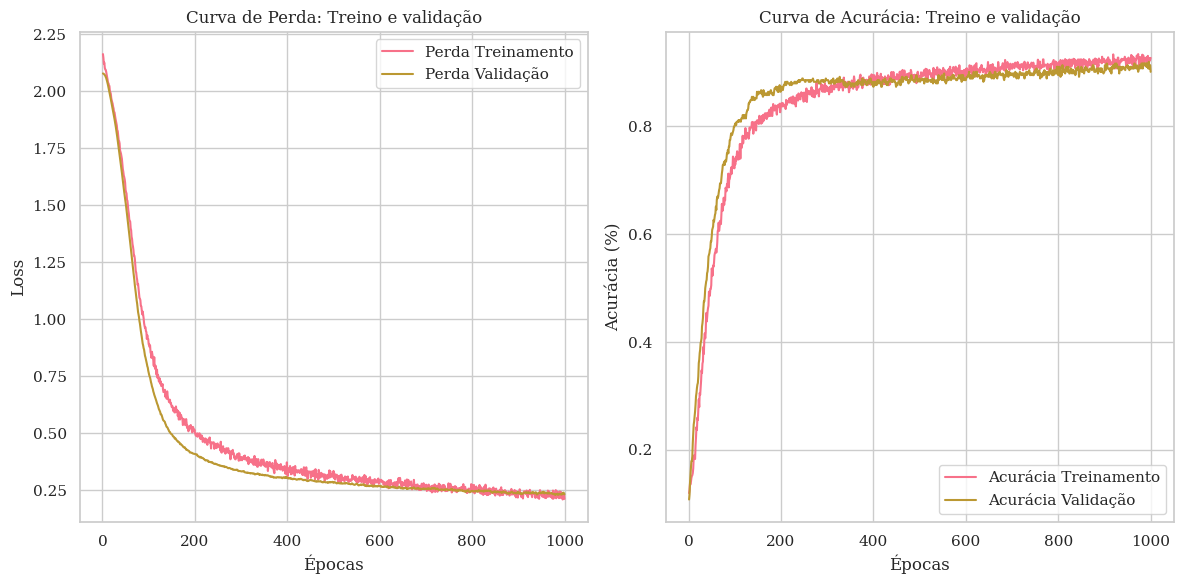

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8501
Usuário 1 Finalizado: Acurácia=0.8500, Recall=0.8500, F1=0.8501
--------------------------------------------------
Processando Usuário 2
x_train: torch.Size([2160, 9, 250])
X_test: torch.Size([240, 9, 250])
Y_treino: torch.Size([2160])
Y_teste: torch.Size([240])


C:\Users\machi\AppData\Local\Temp\ipykernel_21544\3772545045.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs)):


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1192, Train Accuracy: 0.1383, Val Loss: 2.0766, Val Accuracy: 0.1142
Epoch 2/1000: Train Loss: 2.1121, Train Accuracy: 0.1345, Val Loss: 2.0751, Val Accuracy: 0.1512
Epoch 3/1000: Train Loss: 2.0930, Train Accuracy: 0.1514, Val Loss: 2.0728, Val Accuracy: 0.1605
Epoch 4/1000: Train Loss: 2.0995, Train Accuracy: 0.1345, Val Loss: 2.0698, Val Accuracy: 0.1698
Epoch 5/1000: Train Loss: 2.0881, Train Accuracy: 0.1465, Val Loss: 2.0655, Val Accuracy: 0.1883
Epoch 6/1000: Train Loss: 2.0647, Train Accuracy: 0.1672, Val Loss: 2.0602, Val Accuracy: 0.2006
Epoch 7/1000: Train Loss: 2.0646, Train Accuracy: 0.1716, Val Loss: 2.0538, Val Accuracy: 0.2160
Epoch 8/1000: Train Loss: 2.0616, Train Accuracy: 0.1650, Val Loss: 2.0464, Val Accuracy: 0.2315
Epoch 9/1000: Train Loss: 2.0434, Train Accuracy: 0.1879, Val Loss: 2.0379, Val Accuracy: 0.2407
Epoch 10/1000: Train Loss: 2.0314, Train Accuracy: 0.1939, Val Loss: 2.0284, Val Accuracy: 0.2407
Epoch 11/1000: Train Loss: 2.

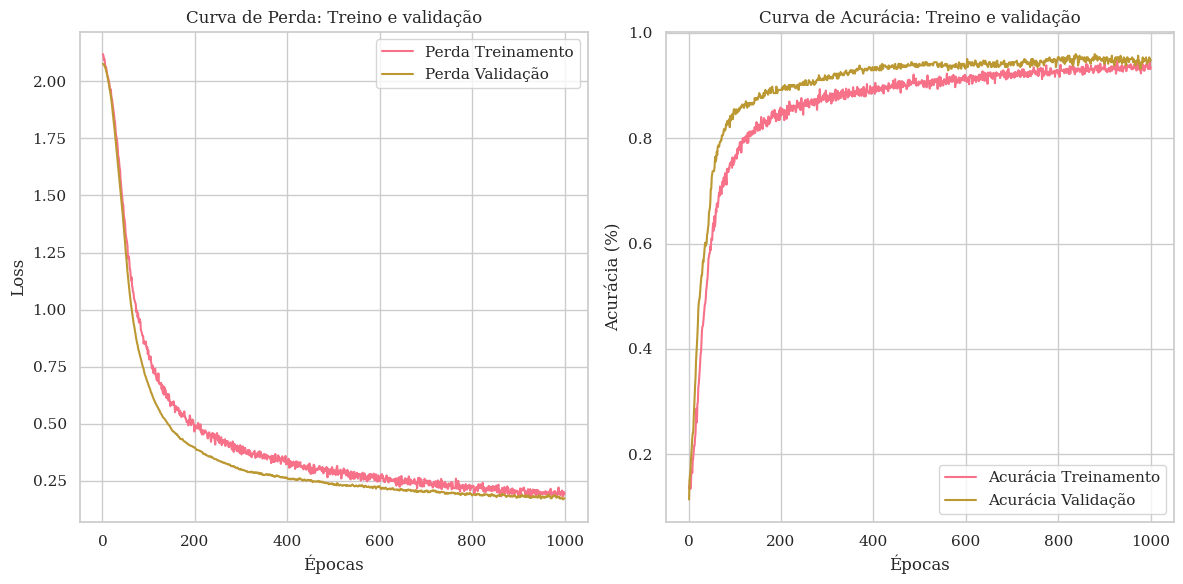

Test set Accuracy: 0.8542
Recall: 0.8542
F1 Score: 0.8556
Usuário 2 Finalizado: Acurácia=0.8542, Recall=0.8542, F1=0.8556
--------------------------------------------------
Processando Usuário 3
x_train: torch.Size([2160, 9, 250])
X_test: torch.Size([240, 9, 250])
Y_treino: torch.Size([2160])
Y_teste: torch.Size([240])


C:\Users\machi\AppData\Local\Temp\ipykernel_21544\3772545045.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs)):


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1459, Train Accuracy: 0.1291, Val Loss: 2.0817, Val Accuracy: 0.1389
Epoch 2/1000: Train Loss: 2.1159, Train Accuracy: 0.1411, Val Loss: 2.0800, Val Accuracy: 0.1420
Epoch 3/1000: Train Loss: 2.1020, Train Accuracy: 0.1378, Val Loss: 2.0781, Val Accuracy: 0.1543
Epoch 4/1000: Train Loss: 2.0909, Train Accuracy: 0.1427, Val Loss: 2.0752, Val Accuracy: 0.1605
Epoch 5/1000: Train Loss: 2.0739, Train Accuracy: 0.1531, Val Loss: 2.0715, Val Accuracy: 0.1667
Epoch 6/1000: Train Loss: 2.0690, Train Accuracy: 0.1721, Val Loss: 2.0663, Val Accuracy: 0.1821
Epoch 7/1000: Train Loss: 2.0596, Train Accuracy: 0.1607, Val Loss: 2.0602, Val Accuracy: 0.1975
Epoch 8/1000: Train Loss: 2.0424, Train Accuracy: 0.1906, Val Loss: 2.0525, Val Accuracy: 0.2099
Epoch 9/1000: Train Loss: 2.0381, Train Accuracy: 0.1934, Val Loss: 2.0435, Val Accuracy: 0.2315
Epoch 10/1000: Train Loss: 2.0277, Train Accuracy: 0.1983, Val Loss: 2.0329, Val Accuracy: 0.2284
Epoch 11/1000: Train Loss: 2.

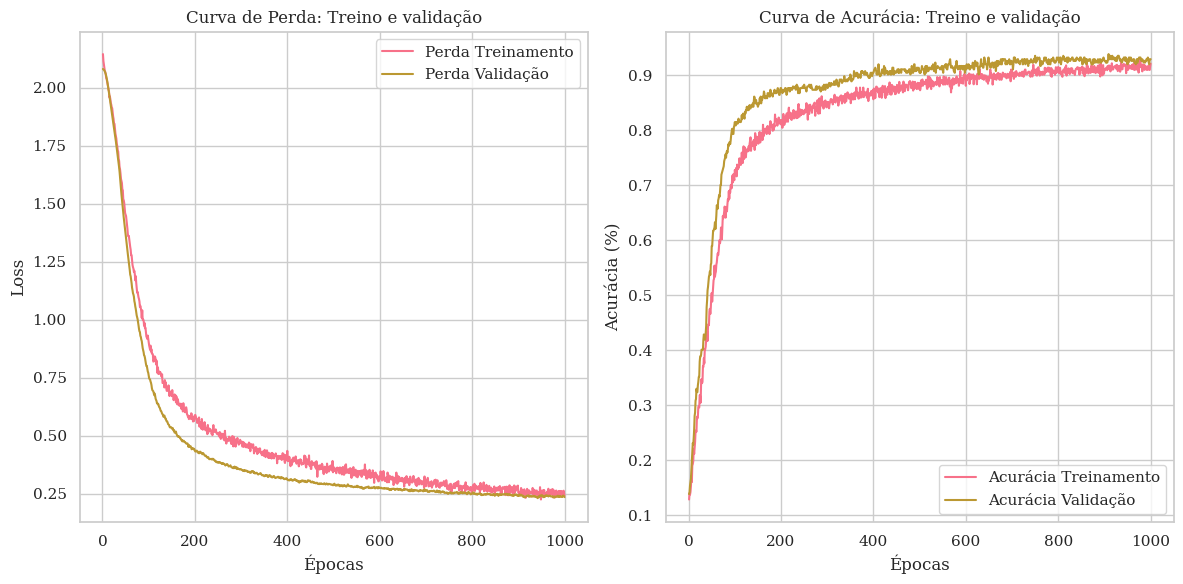

Test set Accuracy: 0.9667
Recall: 0.9667
F1 Score: 0.9665
Usuário 3 Finalizado: Acurácia=0.9667, Recall=0.9667, F1=0.9665
--------------------------------------------------
Processando Usuário 4
x_train: torch.Size([2160, 9, 250])
X_test: torch.Size([240, 9, 250])
Y_treino: torch.Size([2160])
Y_teste: torch.Size([240])


C:\Users\machi\AppData\Local\Temp\ipykernel_21544\3772545045.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs)):


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1320, Train Accuracy: 0.1176, Val Loss: 2.0751, Val Accuracy: 0.1296
Epoch 2/1000: Train Loss: 2.1062, Train Accuracy: 0.1313, Val Loss: 2.0729, Val Accuracy: 0.1481
Epoch 3/1000: Train Loss: 2.0859, Train Accuracy: 0.1509, Val Loss: 2.0698, Val Accuracy: 0.1883
Epoch 4/1000: Train Loss: 2.0872, Train Accuracy: 0.1525, Val Loss: 2.0654, Val Accuracy: 0.1975
Epoch 5/1000: Train Loss: 2.0817, Train Accuracy: 0.1422, Val Loss: 2.0600, Val Accuracy: 0.2191
Epoch 6/1000: Train Loss: 2.0514, Train Accuracy: 0.1819, Val Loss: 2.0534, Val Accuracy: 0.2500
Epoch 7/1000: Train Loss: 2.0516, Train Accuracy: 0.1776, Val Loss: 2.0455, Val Accuracy: 0.2747
Epoch 8/1000: Train Loss: 2.0384, Train Accuracy: 0.1928, Val Loss: 2.0358, Val Accuracy: 0.2716
Epoch 9/1000: Train Loss: 2.0226, Train Accuracy: 0.2124, Val Loss: 2.0247, Val Accuracy: 0.3117
Epoch 10/1000: Train Loss: 2.0179, Train Accuracy: 0.2146, Val Loss: 2.0126, Val Accuracy: 0.3333
Epoch 11/1000: Train Loss: 2.

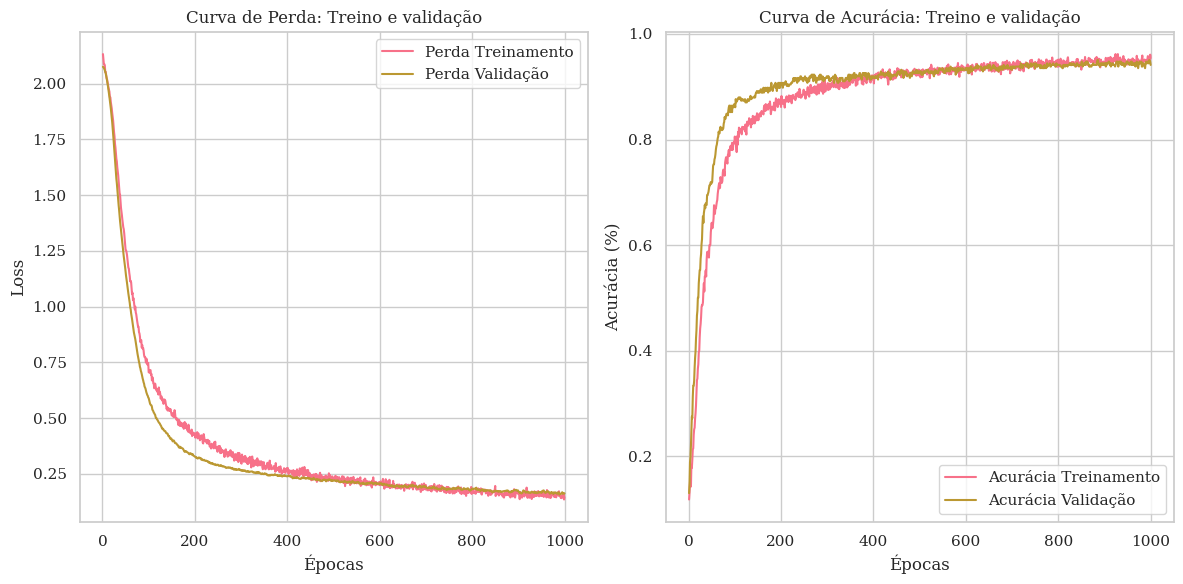

Test set Accuracy: 0.3958
Recall: 0.3958
F1 Score: 0.3822
Usuário 4 Finalizado: Acurácia=0.3958, Recall=0.3958, F1=0.3822
--------------------------------------------------
Processando Usuário 5
x_train: torch.Size([2160, 9, 250])
X_test: torch.Size([240, 9, 250])
Y_treino: torch.Size([2160])
Y_teste: torch.Size([240])


C:\Users\machi\AppData\Local\Temp\ipykernel_21544\3772545045.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs)):


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1354, Train Accuracy: 0.1231, Val Loss: 2.0782, Val Accuracy: 0.1049
Epoch 2/1000: Train Loss: 2.1243, Train Accuracy: 0.1253, Val Loss: 2.0754, Val Accuracy: 0.1296
Epoch 3/1000: Train Loss: 2.0960, Train Accuracy: 0.1471, Val Loss: 2.0723, Val Accuracy: 0.1543
Epoch 4/1000: Train Loss: 2.0984, Train Accuracy: 0.1536, Val Loss: 2.0683, Val Accuracy: 0.1512
Epoch 5/1000: Train Loss: 2.0799, Train Accuracy: 0.1612, Val Loss: 2.0639, Val Accuracy: 0.1759
Epoch 6/1000: Train Loss: 2.0709, Train Accuracy: 0.1601, Val Loss: 2.0582, Val Accuracy: 0.1821
Epoch 7/1000: Train Loss: 2.0605, Train Accuracy: 0.1754, Val Loss: 2.0508, Val Accuracy: 0.2130
Epoch 8/1000: Train Loss: 2.0552, Train Accuracy: 0.1846, Val Loss: 2.0429, Val Accuracy: 0.2191
Epoch 9/1000: Train Loss: 2.0464, Train Accuracy: 0.1966, Val Loss: 2.0346, Val Accuracy: 0.2377
Epoch 10/1000: Train Loss: 2.0270, Train Accuracy: 0.2086, Val Loss: 2.0250, Val Accuracy: 0.2377
Epoch 11/1000: Train Loss: 2.

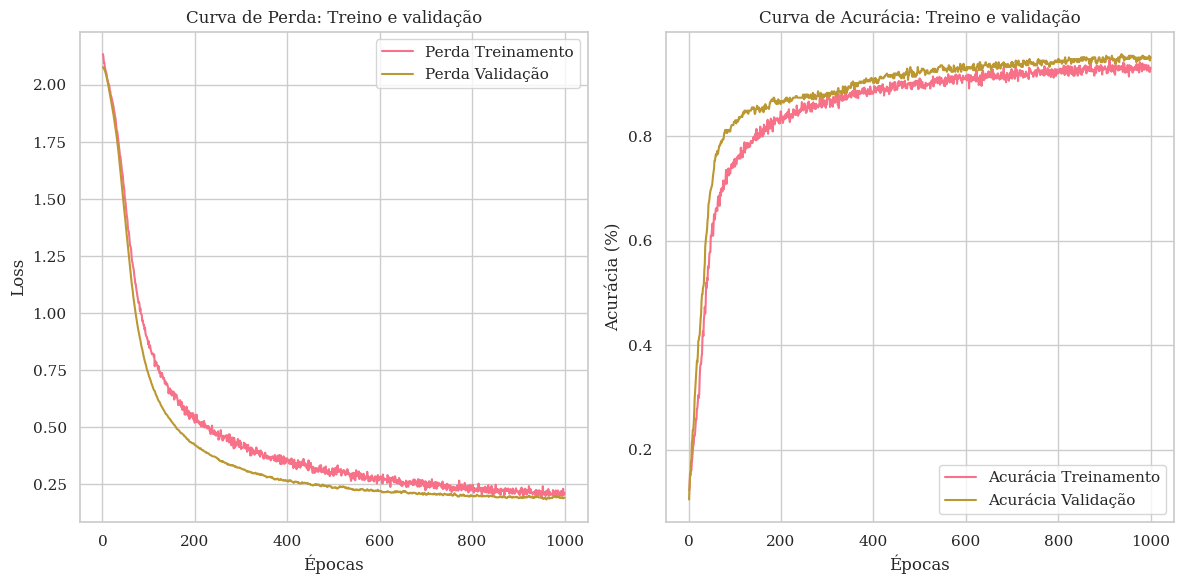

Test set Accuracy: 0.9833
Recall: 0.9833
F1 Score: 0.9834
Usuário 5 Finalizado: Acurácia=0.9833, Recall=0.9833, F1=0.9834
--------------------------------------------------
Processando Usuário 6
x_train: torch.Size([2160, 9, 250])
X_test: torch.Size([240, 9, 250])
Y_treino: torch.Size([2160])
Y_teste: torch.Size([240])


C:\Users\machi\AppData\Local\Temp\ipykernel_21544\3772545045.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs)):


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1621, Train Accuracy: 0.1291, Val Loss: 2.0835, Val Accuracy: 0.1111
Epoch 2/1000: Train Loss: 2.1491, Train Accuracy: 0.1215, Val Loss: 2.0824, Val Accuracy: 0.1574
Epoch 3/1000: Train Loss: 2.1304, Train Accuracy: 0.1296, Val Loss: 2.0816, Val Accuracy: 0.1667
Epoch 4/1000: Train Loss: 2.1286, Train Accuracy: 0.1247, Val Loss: 2.0806, Val Accuracy: 0.1574
Epoch 5/1000: Train Loss: 2.1136, Train Accuracy: 0.1438, Val Loss: 2.0789, Val Accuracy: 0.1667
Epoch 6/1000: Train Loss: 2.0914, Train Accuracy: 0.1454, Val Loss: 2.0764, Val Accuracy: 0.1790
Epoch 7/1000: Train Loss: 2.0977, Train Accuracy: 0.1471, Val Loss: 2.0734, Val Accuracy: 0.1821
Epoch 8/1000: Train Loss: 2.0993, Train Accuracy: 0.1509, Val Loss: 2.0698, Val Accuracy: 0.1914
Epoch 9/1000: Train Loss: 2.0791, Train Accuracy: 0.1770, Val Loss: 2.0657, Val Accuracy: 0.1790
Epoch 10/1000: Train Loss: 2.0708, Train Accuracy: 0.1623, Val Loss: 2.0612, Val Accuracy: 0.1914
Epoch 11/1000: Train Loss: 2.

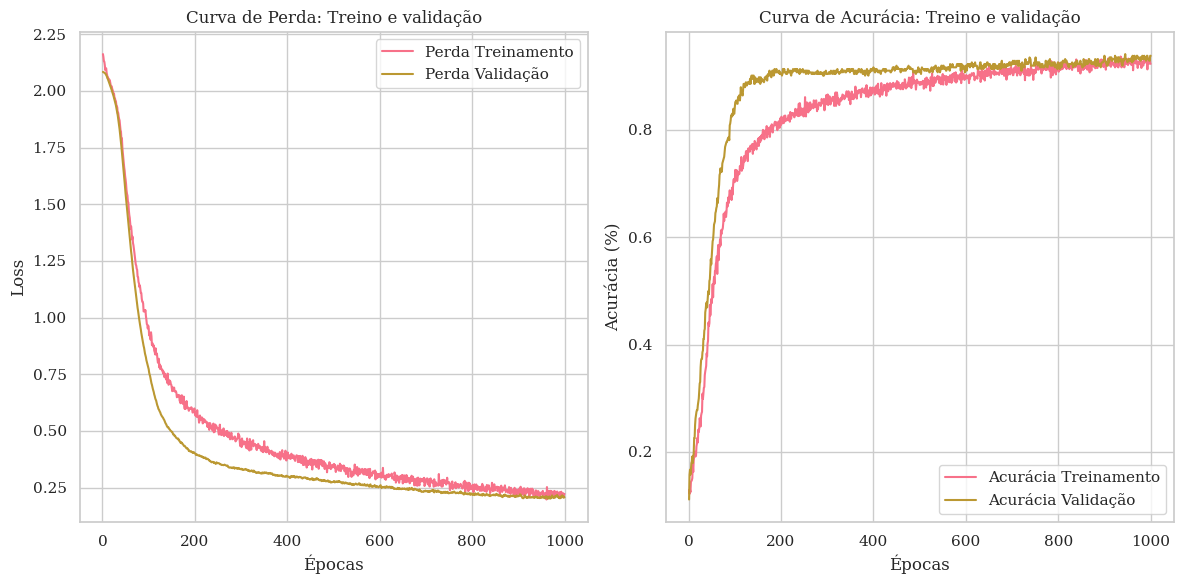

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9498
Usuário 6 Finalizado: Acurácia=0.9500, Recall=0.9500, F1=0.9498
--------------------------------------------------
Processando Usuário 7
x_train: torch.Size([2160, 9, 250])
X_test: torch.Size([240, 9, 250])
Y_treino: torch.Size([2160])
Y_teste: torch.Size([240])


C:\Users\machi\AppData\Local\Temp\ipykernel_21544\3772545045.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs)):


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1219, Train Accuracy: 0.1334, Val Loss: 2.0764, Val Accuracy: 0.1235
Epoch 2/1000: Train Loss: 2.1145, Train Accuracy: 0.1247, Val Loss: 2.0738, Val Accuracy: 0.1296
Epoch 3/1000: Train Loss: 2.1056, Train Accuracy: 0.1351, Val Loss: 2.0706, Val Accuracy: 0.1543
Epoch 4/1000: Train Loss: 2.0919, Train Accuracy: 0.1498, Val Loss: 2.0667, Val Accuracy: 0.1636
Epoch 5/1000: Train Loss: 2.0895, Train Accuracy: 0.1432, Val Loss: 2.0615, Val Accuracy: 0.1698
Epoch 6/1000: Train Loss: 2.0713, Train Accuracy: 0.1585, Val Loss: 2.0555, Val Accuracy: 0.1821
Epoch 7/1000: Train Loss: 2.0619, Train Accuracy: 0.1645, Val Loss: 2.0486, Val Accuracy: 0.1975
Epoch 8/1000: Train Loss: 2.0517, Train Accuracy: 0.1901, Val Loss: 2.0403, Val Accuracy: 0.2222
Epoch 9/1000: Train Loss: 2.0563, Train Accuracy: 0.1874, Val Loss: 2.0316, Val Accuracy: 0.2377
Epoch 10/1000: Train Loss: 2.0473, Train Accuracy: 0.1819, Val Loss: 2.0217, Val Accuracy: 0.2562
Epoch 11/1000: Train Loss: 2.

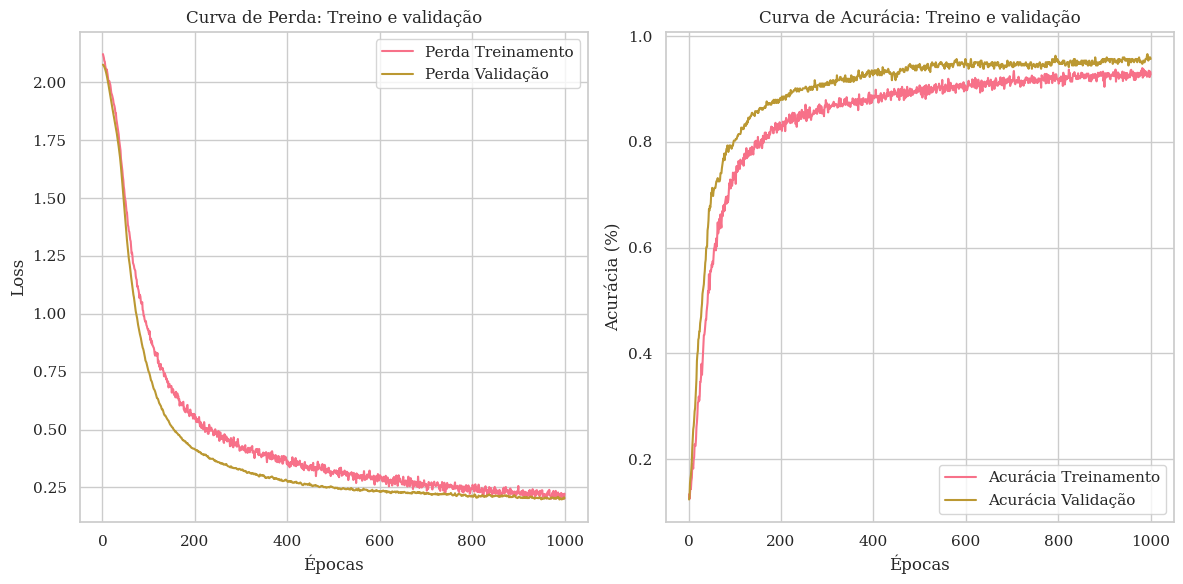

Test set Accuracy: 0.9208
Recall: 0.9208
F1 Score: 0.9210
Usuário 7 Finalizado: Acurácia=0.9208, Recall=0.9208, F1=0.9210
--------------------------------------------------
Processando Usuário 8
x_train: torch.Size([2160, 9, 250])
X_test: torch.Size([240, 9, 250])
Y_treino: torch.Size([2160])
Y_teste: torch.Size([240])


C:\Users\machi\AppData\Local\Temp\ipykernel_21544\3772545045.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs)):


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1467, Train Accuracy: 0.1280, Val Loss: 2.0776, Val Accuracy: 0.1327
Epoch 2/1000: Train Loss: 2.1149, Train Accuracy: 0.1492, Val Loss: 2.0752, Val Accuracy: 0.1574
Epoch 3/1000: Train Loss: 2.1042, Train Accuracy: 0.1313, Val Loss: 2.0725, Val Accuracy: 0.1543
Epoch 4/1000: Train Loss: 2.0975, Train Accuracy: 0.1405, Val Loss: 2.0698, Val Accuracy: 0.1605
Epoch 5/1000: Train Loss: 2.0889, Train Accuracy: 0.1618, Val Loss: 2.0664, Val Accuracy: 0.1667
Epoch 6/1000: Train Loss: 2.0885, Train Accuracy: 0.1514, Val Loss: 2.0624, Val Accuracy: 0.1852
Epoch 7/1000: Train Loss: 2.0716, Train Accuracy: 0.1683, Val Loss: 2.0572, Val Accuracy: 0.1975
Epoch 8/1000: Train Loss: 2.0565, Train Accuracy: 0.1776, Val Loss: 2.0517, Val Accuracy: 0.2099
Epoch 9/1000: Train Loss: 2.0611, Train Accuracy: 0.1688, Val Loss: 2.0464, Val Accuracy: 0.2253
Epoch 10/1000: Train Loss: 2.0403, Train Accuracy: 0.2075, Val Loss: 2.0405, Val Accuracy: 0.2253
Epoch 11/1000: Train Loss: 2.

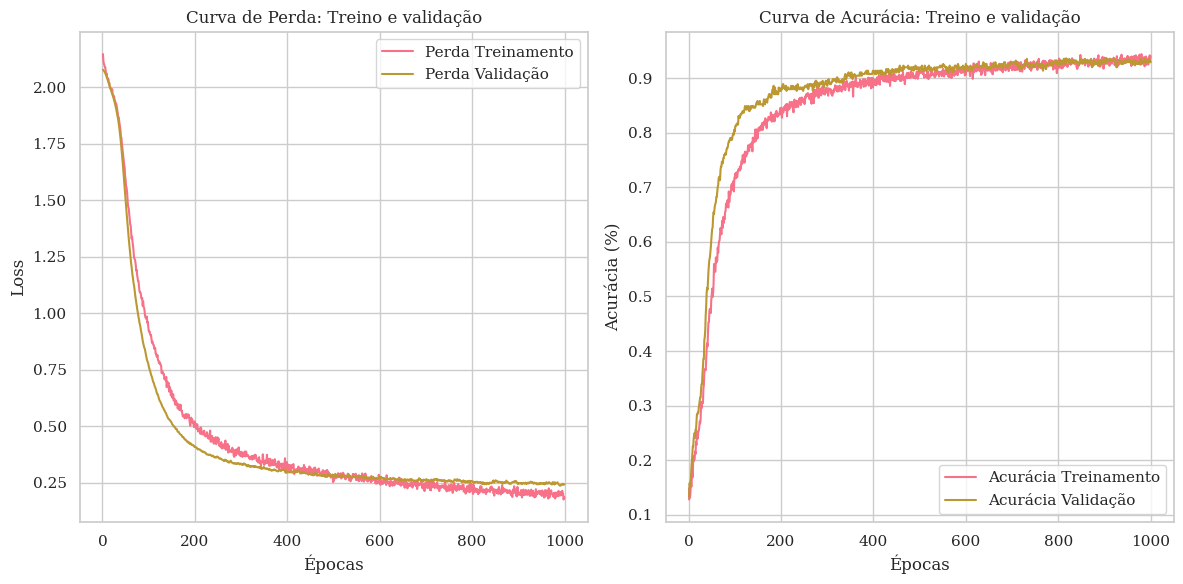

Test set Accuracy: 0.9292
Recall: 0.9292
F1 Score: 0.9289
Usuário 8 Finalizado: Acurácia=0.9292, Recall=0.9292, F1=0.9289
--------------------------------------------------
Processando Usuário 9
x_train: torch.Size([2160, 9, 250])
X_test: torch.Size([240, 9, 250])
Y_treino: torch.Size([2160])
Y_teste: torch.Size([240])


C:\Users\machi\AppData\Local\Temp\ipykernel_21544\3772545045.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs)):


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1343, Train Accuracy: 0.1253, Val Loss: 2.0811, Val Accuracy: 0.1049
Epoch 2/1000: Train Loss: 2.1184, Train Accuracy: 0.1275, Val Loss: 2.0806, Val Accuracy: 0.1204
Epoch 3/1000: Train Loss: 2.1023, Train Accuracy: 0.1275, Val Loss: 2.0799, Val Accuracy: 0.1296
Epoch 4/1000: Train Loss: 2.0963, Train Accuracy: 0.1367, Val Loss: 2.0783, Val Accuracy: 0.1327
Epoch 5/1000: Train Loss: 2.0783, Train Accuracy: 0.1574, Val Loss: 2.0759, Val Accuracy: 0.1451
Epoch 6/1000: Train Loss: 2.0668, Train Accuracy: 0.1645, Val Loss: 2.0720, Val Accuracy: 0.1605
Epoch 7/1000: Train Loss: 2.0569, Train Accuracy: 0.1748, Val Loss: 2.0670, Val Accuracy: 0.1728
Epoch 8/1000: Train Loss: 2.0550, Train Accuracy: 0.1944, Val Loss: 2.0599, Val Accuracy: 0.1821
Epoch 9/1000: Train Loss: 2.0311, Train Accuracy: 0.1901, Val Loss: 2.0508, Val Accuracy: 0.1975
Epoch 10/1000: Train Loss: 2.0249, Train Accuracy: 0.2059, Val Loss: 2.0411, Val Accuracy: 0.2160
Epoch 11/1000: Train Loss: 2.

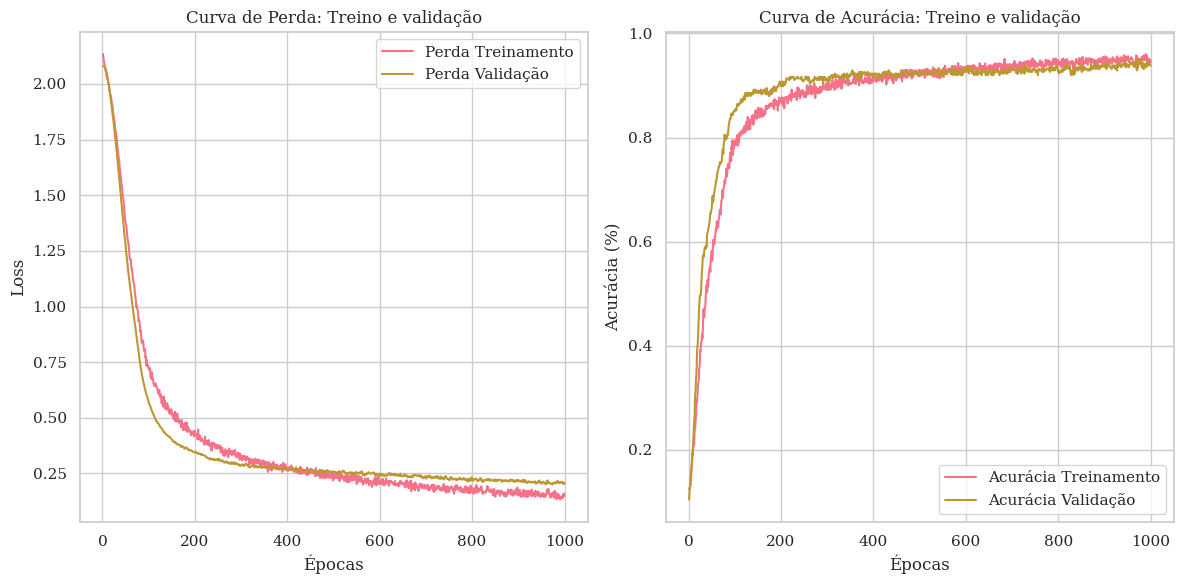

Test set Accuracy: 0.6458
Recall: 0.6458
F1 Score: 0.6513
Usuário 9 Finalizado: Acurácia=0.6458, Recall=0.6458, F1=0.6513
--------------------------------------------------
Processando Usuário 10
x_train: torch.Size([2160, 9, 250])
X_test: torch.Size([240, 9, 250])
Y_treino: torch.Size([2160])
Y_teste: torch.Size([240])


C:\Users\machi\AppData\Local\Temp\ipykernel_21544\3772545045.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs)):


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1378, Train Accuracy: 0.1111, Val Loss: 2.0788, Val Accuracy: 0.1142
Epoch 2/1000: Train Loss: 2.1076, Train Accuracy: 0.1438, Val Loss: 2.0773, Val Accuracy: 0.1605
Epoch 3/1000: Train Loss: 2.1163, Train Accuracy: 0.1334, Val Loss: 2.0758, Val Accuracy: 0.1636
Epoch 4/1000: Train Loss: 2.0827, Train Accuracy: 0.1481, Val Loss: 2.0737, Val Accuracy: 0.1636
Epoch 5/1000: Train Loss: 2.0792, Train Accuracy: 0.1569, Val Loss: 2.0710, Val Accuracy: 0.1698
Epoch 6/1000: Train Loss: 2.0684, Train Accuracy: 0.1569, Val Loss: 2.0674, Val Accuracy: 0.1698
Epoch 7/1000: Train Loss: 2.0579, Train Accuracy: 0.1814, Val Loss: 2.0631, Val Accuracy: 0.1821
Epoch 8/1000: Train Loss: 2.0504, Train Accuracy: 0.1607, Val Loss: 2.0572, Val Accuracy: 0.1975
Epoch 9/1000: Train Loss: 2.0431, Train Accuracy: 0.1781, Val Loss: 2.0504, Val Accuracy: 0.2130
Epoch 10/1000: Train Loss: 2.0270, Train Accuracy: 0.1955, Val Loss: 2.0430, Val Accuracy: 0.2130
Epoch 11/1000: Train Loss: 2.

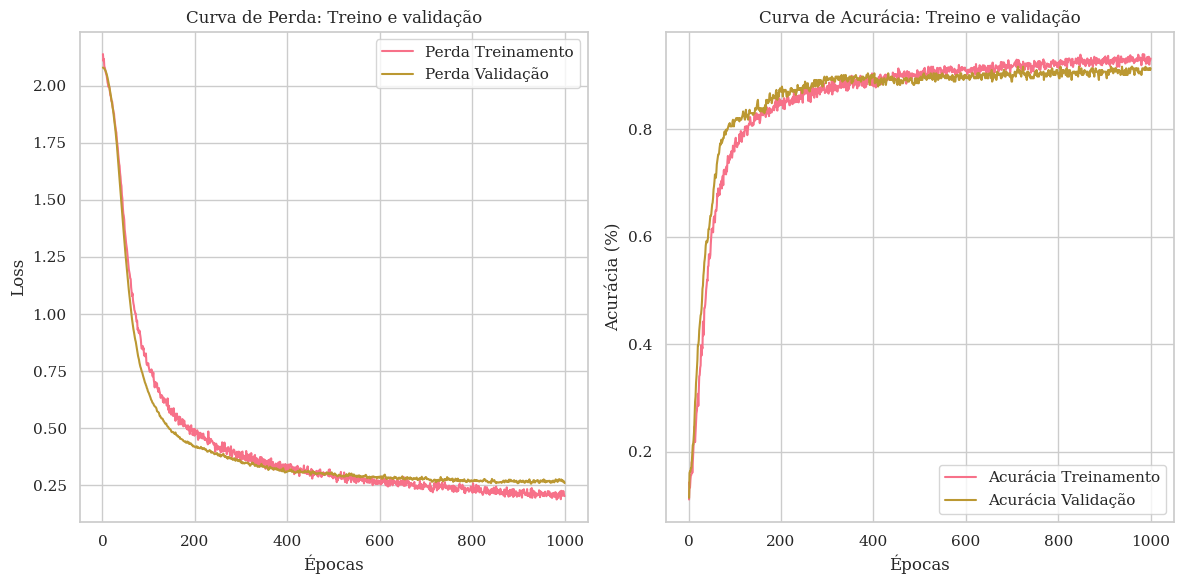

Test set Accuracy: 0.9458
Recall: 0.9458
F1 Score: 0.9438
Usuário 10 Finalizado: Acurácia=0.9458, Recall=0.9458, F1=0.9438
--------------------------------------------------


In [53]:
seed = 42
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)

# Lista para armazenar as métricas de todos os usuários e sessões
metricas_usuarios = []

# Leave-one-user-out cross-validation
for user in range(1, len(all_data) + 1):
    print(f"Processando Usuário {user}")

    n_freqs_sel = len(indices)

    metricas_crossval = []

    users_train = [u for u in range(1, len(all_data) + 1) if u != user]
    user_test = user

    x_train = []
    labels_train = []

    x_test = []
    labels_test = []

    for u in users_train:
        data = all_data[u - 1]
        for session in range(data.shape[3]):
            for freq in range(len(indices)):
                eeg_trial = data[occipital_electrodes, :, indices[freq], session]

                eeg_trial_janelas, numero_janelas = separar_em_janelas(
                    eeg_trial.T, tamanho_da_janela
                )
                eeg_trial_janelas_array = np.stack(eeg_trial_janelas)
                eeg_trial_janelas_array = eeg_trial_janelas_array.transpose(0, 2, 1)

                # print(eeg_trial_janelas_array.shape)

                x_train.append(eeg_trial_janelas_array)

                # Adiciona um rótulo 'freq' para cada janela gerada
                labels_train.extend([frequencias[freq]] * numero_janelas)
    x_train = np.concatenate(x_train, axis=0)

    data = all_data[user_test - 1]
    for session in range(data.shape[3]):
        for freq in range(len(indices)):

            eeg_trial = data[occipital_electrodes, :, indices[freq], session]

            eeg_trial_janelas, numero_janelas = separar_em_janelas(
                eeg_trial.T, tamanho_da_janela
            )
            eeg_trial_janelas_array = np.stack(eeg_trial_janelas)
            eeg_trial_janelas_array = eeg_trial_janelas_array.transpose(0, 2, 1)
            x_test.append(eeg_trial_janelas_array)
            # Adiciona um rótulo 'freq' para cada janela gerada
            labels_test.extend([frequencias[freq]] * numero_janelas)

    x_test = np.concatenate(x_test, axis=0)

    # Mapeamento de rótulos
    mapeamento = {rotulo: i for i, rotulo in enumerate(sorted(frequencias_desejadas))}
    rotulos_treinamento = torch.tensor(
        [mapeamento[rotulo.item()] for rotulo in labels_train]
    )
    labels_test = torch.tensor([mapeamento[rotulo.item()] for rotulo in labels_test])

    # Converter para tensores
    x_train = torch.from_numpy(x_train.copy()).float().to(device)
    X_test = torch.from_numpy(x_test.copy()).float().to(device)
    Y_treino = rotulos_treinamento.to(torch.long).to(device)
    Y_teste = labels_test.to(torch.long).to(device)

    print("x_train:", x_train.shape)
    print("X_test:", X_test.shape)
    print("Y_treino:", Y_treino.shape)
    print("Y_teste:", Y_teste.shape)

    # Configurar modelo e treinamento
    model = EEGNetv4(
        n_chans=9,
        n_outputs=len(frequencias_desejadas),
        n_times=tamanho_da_janela,
        kernel_length=(tamanho_da_janela // 2),
    )
    model = model.to(device)

    dataset = TensorDataset(x_train, Y_treino)
    train_size = int(0.85 * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(
        dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(seed),
    )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(
        TensorDataset(X_test, Y_teste), batch_size=10, shuffle=False
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    # Treinar
    best_model = train(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=epochs,
        device=device,
        save_path=f"best_model_user_{user}.pth",
    )

    # Avaliar
    accuracy, recall, f1 = evaluate(
        best_model, test_loader, chanels=len(frequencias_desejadas)
    )

    # Armazenar métricas
    metricas_crossval.append(
        {
            "usuario": user,
            "acuracia": accuracy,
            "recall": recall,
            "f1-score": f1,
        }
    )

    print(
        f"Usuário {user} Finalizado: Acurácia={accuracy:.4f}, Recall={recall:.4f}, F1={f1:.4f}"
    )

    # Salvar as métricas de cada usuário
    metricas_usuarios.extend(metricas_crossval)
    # =====================================
    # Salvar resultados finais em CSV
    # =====================================

    # Criar um DataFrame com as métricas
    df_metricas = pd.DataFrame(metricas_usuarios)

    # Salvar como CSV
    df_metricas.to_csv("metricas_treinamento_1_segundos_dados_brutos.csv", index=False)

    print("-" * 50)